# Barren Plateaus
Author: Gopal Ramesh Dahale

In [1]:
!pip install -q qiskit pylatexenc
!pip install -q git+https://github.com/Gopal-Dahale/qiskit-qulacs.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.utils import algorithm_globals
from qiskit.quantum_info import SparsePauliOp

from qiskit_qulacs.qulacs_estimator import QulacsEstimator
from qiskit_qulacs.qulacs_estimator_gradient import QulacsEstimatorGradient

import pandas as pd
from time import time
import matplotlib.pyplot as plt
import multiprocessing
from itertools import product
import seaborn as sns
import numpy as np

seed = 42
np.random.seed(seed)
algorithm_globals.random_seed = seed

sns.set_style("whitegrid")

In [3]:
def generate_random_pqc(n_qubits, n_layers):

    qc = QuantumCircuit(n_qubits)

    theta = Parameter('θ')

    for q in range(n_qubits):
        qc.ry(np.pi / 4, q)

    qc.barrier()

    for l in range(n_layers):

        for q in range(n_qubits):

            if (q != 0) or (l != 0):
                val = np.random.uniform(0, 2 * np.pi)
            else:
                val = theta

            num = np.random.randint(3)

            if num == 0:
                qc.rx(val, q)
            elif num == 1:
                qc.ry(val, q)
            else:
                qc.rz(val, q)

        for q in range(0, n_qubits - 1, 2):
            qc.cz(q, q + 1)
        for q in range(1, n_qubits - 1, 2):
            qc.cz(q, q + 1)

        qc.barrier()

    return qc

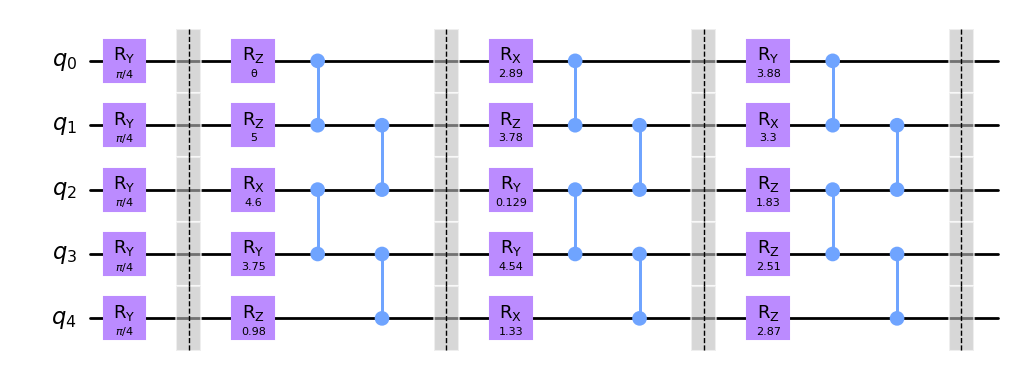

In [4]:
circ = generate_random_pqc(5, 3)
circ.draw('mpl')

In [5]:
qubits = range(2, 12, 2)
layers = [1, 3, 5, 10, 15, 20, 50, 100, 200]

comb = product(layers, qubits)

n_samples = 500

estimator = QulacsEstimator()
gradient = QulacsEstimatorGradient(estimator)

def run(nl, nq):

    circs = [generate_random_pqc(nq, nl) for _ in range(n_samples)]
    op = SparsePauliOp(['I'*(nq-2) + 'ZZ'])

    parameter_values = np.random.uniform(0, 2 * np.pi, (n_samples, 1))

    grads = gradient.run(circs, [op] * n_samples,
                         parameter_values).result().gradients

    var = np.std(np.array(grads)[:, -1])

    return [nl, nq, var]


s = time()

with multiprocessing.Pool() as pool:
    data = pool.starmap(run, comb)
    df = pd.DataFrame(np.array(data), columns=['layers', 'qubits', 'variance'])
    df.to_csv('gradient_variance.csv', index=False)

e = time()

In [6]:
print('Duration:', e-s)

Duration: 1031.7766454219818


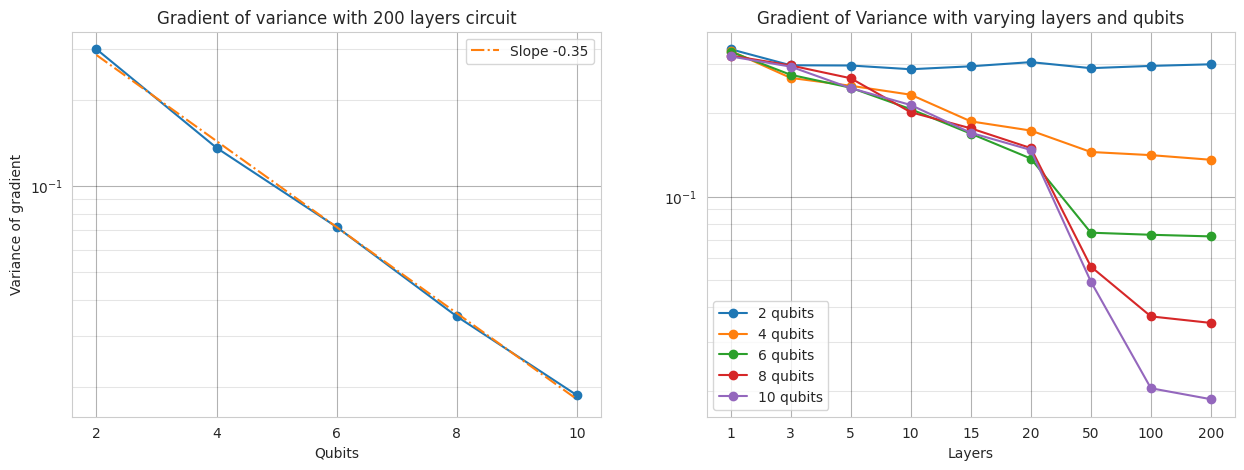

In [7]:
df = pd.read_csv('gradient_variance.csv')
grouped_df = df.groupby('qubits')

fig, ax = plt.subplots(1,2,figsize=(15,5))

for nq in qubits:
    group = grouped_df.get_group(nq)
    nlayers = np.array(group.layers.tolist(), dtype=np.int32)

    var = group.variance.tolist()

    a = np.arange(len(nlayers))

    ax[1].plot(a, var, marker='o', label=f'{nq} qubits')
    ax[1].xaxis.set_ticks(a) # set the ticks to be a
    ax[1].xaxis.set_ticklabels(nlayers) # change the ticks' names to x

    ax[1].set_yscale('log')
    ax[1].set_xlabel('Layers')
    ax[1].set_title('Gradient of Variance with varying layers and qubits')
    ax[1].legend()
    ax[1].grid(which="major", color="black", linestyle="-", alpha=0.3)
    ax[1].grid(which="minor", color="black", linestyle="-", alpha=0.1)


qubit_df = df.groupby('layers').get_group(layers[-1])

nqubits = np.array(qubit_df.qubits, dtype=np.int32)
var = qubit_df.variance.tolist()
p = np.polyfit(nqubits, np.log(var), 1)
a = np.arange(len(nqubits))

ax[0].plot(a, var, marker='o')
ax[0].plot(a, np.exp(p[0] * nqubits + p[1]), '-.', label="Slope {:3.2f}".format(p[0]))
ax[0].xaxis.set_ticks(a) # set the ticks to be a
ax[0].xaxis.set_ticklabels(nqubits) # change the ticks' names to x

ax[0].set_yscale('log')
ax[0].set_xlabel('Qubits')
ax[0].set_ylabel('Variance of gradient')
ax[0].set_title(f'Gradient of variance with {layers[-1]} layers circuit')
ax[0].legend()
ax[0].grid(which="major", color="black", linestyle="-", alpha=0.3)
ax[0].grid(which="minor", color="black", linestyle="-", alpha=0.1)

In [8]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright